# Example to use ODA

In [1]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import cv2
import matplotlib.pyplot as plt

from utils.cococls import get_cls

import numpy as np

In [2]:
cococlass = get_cls() # for viz
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True).to(device).eval()

## load img

In [4]:
def loadimg(path):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    img = cv2.imread(path)
    img = cv2.resize(img, (1024,1024))
    img = img.transpose([2,0,1]) / 255 # 0-1 float!
    return torch.from_numpy(img).unsqueeze(0).to(device).float()

# Execute TTA with ODA

In [49]:
import time
start = time.time()
impath = "imgs/cars3.jpg"
img = loadimg(impath)

with torch.no_grad():
    results = model(img)
print("inference:", time.time()-start)

boxes = results[0]["boxes"].cpu().numpy()/1024
scores = results[0]["scores"].cpu().numpy()
labels = results[0]["labels"].cpu().numpy()

inference: 0.28589749336242676


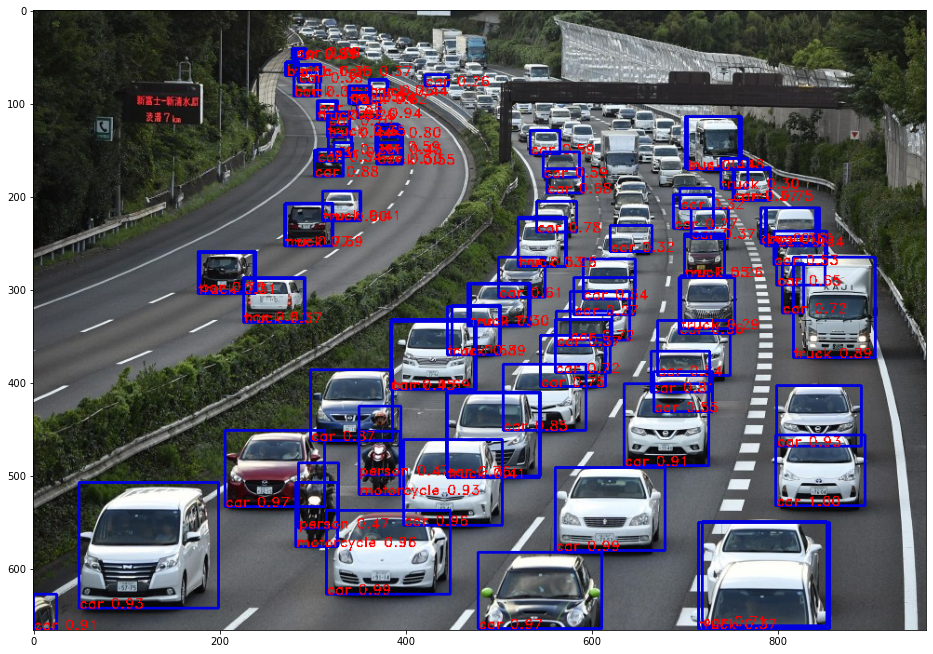

In [50]:
# Viz
fig = plt.figure(figsize=(16,16))
sample = cv2.imread(impath)
# rescale boxes to image size
boxes[:,0] *= sample.shape[1]
boxes[:,2] *= sample.shape[1]
boxes[:,1] *= sample.shape[0]
boxes[:,3] *= sample.shape[0]
for i, box in enumerate(boxes):
    cv2.rectangle(sample,
              (int(box[0]), int(box[1])),
              (int(box[2]), int(box[3])),
              220, 2)
    cv2.putText(sample, cococlass[labels[i]] + " {:.2f}".format(scores[i]), (int(box[0]), int(box[3])),  
                cv2.FONT_HERSHEY_DUPLEX, 0.5, (0,0,255), 1) # Write the prediction class

plt.imshow(sample[:,:,::-1])#BGR2RGB
plt.show()

In [67]:
# https://github.com/matterport/Mask_RCNN/blob/3deaec5d902d16e1daf56b62d5971d428dc920bc/mrcnn/visualize.py#L59
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask >0.5,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


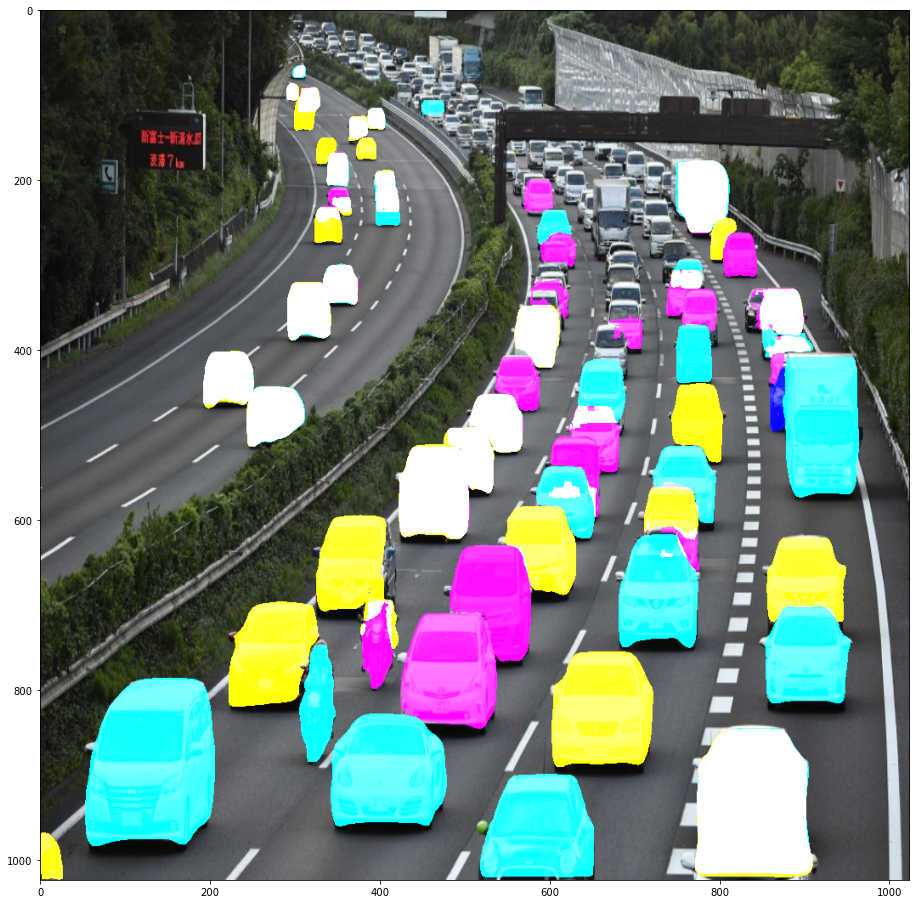

In [69]:
import colorsys
import random
fig = plt.figure(figsize=(16,16))

masks = results[0]["masks"].cpu().numpy()

sample = cv2.resize(cv2.imread(impath), (1024,1024))/255
# rescale boxes to image size
boxes[:,0] *= sample.shape[1]
boxes[:,2] *= sample.shape[1]
boxes[:,1] *= sample.shape[0]
boxes[:,3] *= sample.shape[0]

colors = random_colors(len(masks))
for i,mask in enumerate(masks):
    color = colors[i]
    mask = mask[0]
    #contours = find_contours(padded_mask, 0.5)
    sample = apply_mask(sample, mask, color)
    
plt.imshow(sample[:,:,::-1])#BGR2RGB
plt.show()